In [1]:
import os
import time
import pandas as pd
import numpy as np
import warnings
import statsmodels.api as sm
from tqdm import tqdm
import seaborn as sns
import datetime
import time
import matplotlib.pyplot as plt
import statsmodels.stats as stat
import sys
import scipy.stats as stat
import sympy as sy
from sympy.stats import Normal, cdf
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold,KFold
import sklearn
import joblib
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import lightgbm as lgb
from datetime import datetime
torch.cuda.empty_cache()
tqdm.pandas(desc="my bars:")
warnings.filterwarnings("ignore")

In [2]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz 
!tar xvzf ta-lib-0.4.0-src.tar.gz
import os
os.chdir('ta-lib') 
!./configure --prefix=/usr
!make
!make install

os.chdir('../')
!pip install TA-Lib

--2022-08-24 21:01:13--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-08-24 21:01:14--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://netix.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-08-24 21:01:14--  http://netix.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving netix.dl.sourceforg

In [3]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [4]:
def euro_vanilla_option(S, K, T, r,sigma,isCall):
    '''
    bs formula
    '''
    d1 = (np.log(S / K) + (r  + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r  - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if isCall == 1:
        phi = 1
    else:
        phi = -1
    
    return phi*(S*stat.norm.cdf(phi*d1) - K*np.exp(-r*T)*stat.norm.cdf(phi*d2))

def BS_price(df):
    k = df['strike price']
    s = df['spot price']
    iscall = df['C']
    expiry = df['time_to_mature']
    rf = df['riskfree rate']
    sigma = df['sabr vol']
    return pd.Series({'sabr_value':euro_vanilla_option(s,k,expiry,rf,sigma,iscall)})

In [5]:
import talib
#feature engineering
def feature_engineering(data):
    df = data.copy()
    df['close_ma_25min'] = talib.MA(df['close'],5)
    df['close_ma_75min'] = talib.MA(df['close'],15)
    df['close_ema_25min'] = talib.EMA(df['close'],5)
    df['close_ema_75min'] = talib.EMA(df['close'],15)
    df['close_ma_diff_5'] = df['close'] - df['close_ma_25min']
    df['close_ema_diff_5'] = df['close'] - df['close_ema_25min']
    df['volume_ema_50min'] = talib.EMA(df['volume'],10)
    df['volume_ema_150min'] = talib.EMA(df['volume'],30)
    df['volume_ema_diff'] = df['volume_ema_50min'] - df['volume_ema_150min']
    df['vol_diff'] = df['black vol'] - df['sabr vol']
    df['moneyness'] = df['spot price']/df['strike price']
    df['sabr_value_diff'] = df['close'] - df['sabr_value']
    
    return df
def feature_engineering_vol(data):
    '''
    feature engineering
    '''
    df = data.copy()
    df['close_ema_25min'] = talib.EMA(df['close'],5)
    df['close_ema_75min'] = talib.EMA(df['close'],15)
    df['close_ema_diff_5'] = df['close'] - df['close_ema_25min']
    df['volume_ema_50min'] = talib.EMA(df['volume'],10)
    df['volume_ema_150min'] = talib.EMA(df['volume'],30)
    df['volume_ema_diff'] = df['volume_ema_50min'] - df['volume_ema_150min']
    df['vol_diff'] = df['black vol'] - df['sabr vol']
    df['moneyness'] = df['spot price']/df['strike price']
    df['sabr_vol_diff_min'] = df['sabr vol'] - df['sabr vol'].rolling(60,min_periods = 10).min()
    # df['sabr_vol_diff_max'] = -df['sabr vol'] + df['sabr vol'].rolling(50,min_periods = 10).max()
    df['sabr_value_diff'] = df['close'] - df['sabr_value']
    df['vol_ema_25min'] = talib.EMA(df['sabr vol'],5)
    df['vol_ema_75min'] = talib.EMA(df['sabr vol'],15)
    df['vol_ema_diff_5'] = df['sabr vol'] - df['vol_ema_25min']
    df['vol_ema_diff_15'] = df['sabr vol'] - df['vol_ema_75min']
    df['IV_per_volume'] = df['sabr vol'].diff() / df['volume']
    df['IV_per_volume_diff'] = (df['black vol'] - df['sabr vol']).diff()/df['volume']
    df['sabr_value_per_volume'] = df['sabr_value'].diff()/df['volume']
    df['sabr_value_per_volume_diff'] = (df['close'] - df['sabr_value']).diff()/df['volume']
    df['ret'] = df['close'].pct_change()
    df['cummulative_ret_25min'] = df['ret'].rolling(5).sum()
    df['cummulative_ret_75min'] = df['ret'].rolling(15).sum()
    df['aroon_up_30'],df['aroon_in_30'] = talib.AROON(df['high'],df['close'],30)
    df['CCI'] = talib.CCI(df['high'],df['low'],df['close'],30)
    df['macd_close'] = talib.MACD(df['close'],10,30,6)[0]
    df['macd_sabr_value'] = talib.MACD(df['sabr_value'],10,30)[0]
    df['ULTOSC'] = talib.ULTOSC(df['high'], df['low'], df['close'], timeperiod1=6, timeperiod2=12, timeperiod3=24)
    df['atm_IV_ema_25min'] = talib.EMA(df['atm_IV'],5)
    df['atm_IV_ema_75min'] = talib.EMA(df['atm_IV'],15)
    df['atm_IV_MACD'] = talib.MACD(df['atm_IV'],10,30,6)[0]
       
    return df

In [6]:
def beta_calculation(df):
    '''
    feature engineering with IV curve
    '''
    df = df[['strike','sabr vol','spot price','time','code']]
    df['moneyness'] = (df['spot price']>df['strike']).apply(lambda x:1 if x else 0)
    df_OTM = df[df['moneyness']<1]
    df_ITM = df[df['moneyness']==1]
    beta_OTM_ols = np.cov(df_OTM['sabr vol'],df_OTM['strike'])[0][1]/np.var(df_OTM['strike'])
    beta_ITM_ols = np.cov(df_ITM['sabr vol'],df_ITM['strike'])[0][1]/np.var(df_ITM['strike'])
    if df_OTM['strike'].max() != df_OTM['strike'].min():
        beta_OTM = -(df_OTM['sabr vol'].max() - df_OTM['sabr vol'].min())/ (df_OTM['strike'].max() - df_OTM['strike'].min())
    else:
        beta_OTM = 0
    if df_ITM['strike'].max() != df_ITM['strike'].min():
        beta_ITM = (df_ITM['sabr vol'].max() - df_ITM['sabr vol'].min())/ (df_ITM['strike'].max() - df_ITM['strike'].min())
    else:
        beta_ITM = 0
    df_OTM_sub = df_OTM[df_OTM['strike']>df_OTM['strike'].min()]
    df_ITM_sub = df_ITM[df_ITM['strike']>df_ITM['strike'].min()]
    df_OTM_sub['beta'] = -(df_OTM_sub['sabr vol'] - df_OTM['sabr vol'].min())/(df_OTM_sub['strike'] - df_OTM['strike'].min())
    df_ITM_sub['beta'] = (df_ITM_sub['sabr vol'] - df_ITM['sabr vol'].min())/(df_ITM_sub['strike'] - df_ITM['strike'].min())
    beta_OTM_avg = df_OTM_sub['beta'].mean()
    beta_ITM_avg = df_ITM_sub['beta'].mean()
    
    atm_strike = (df_OTM.strike.max() + df_ITM.strike.min())/2
    atm_vol = (df_OTM['sabr vol'].min() + df_OTM['sabr vol'].min())/2
    df['beta'] = (df['sabr vol'] - atm_vol)/(df['strike'] - atm_strike)
    df.loc[abs(df['beta'])>1,'beta'] = 0
    df['beta_ols_diff'] = abs(df['beta'] - df['moneyness'].apply(lambda x:beta_OTM_ols if x==0 else beta_ITM_ols))
    df['beta_diff'] = abs(df['beta'] - df['moneyness'].apply(lambda x:beta_OTM if x==0 else beta_ITM))
    df['beta_avg_diff'] = abs(df['beta'] - df['moneyness'].apply(lambda x:beta_OTM_avg if x==0 else beta_ITM_avg))
    df['atm_IV'] = atm_vol
    df = df.drop("moneyness",axis=1)
    return df
#vol_beta = option2207_sabr.groupby('time',as_index=True).progress_apply(lambda x:beta_calculation(x))

In [7]:
def make_dataset(data,y_pred='f_close_5min'):
    '''
    make dataset, y_pred: the label name {'f_close_5min','f_ret_5min','f_ret_direction'}
    '''
    feature = data.copy()
    if y_pred =="f_close_5min":
        feature['f_close_5min'] = feature.groupby('code').apply(lambda x:x['close'].shift(-1)).values
    elif y_pred == "f_ret_5min":
        feature['f_ret_5min'] = feature.groupby('code').apply(lambda x:x['close'].pct_change().shift(-1)).values
    elif y_pred == "f_ret_direction":
        feature['f_ret_direction'] = ((feature.groupby('code').apply(lambda x:x['close'].shift(-1)))>0).apply(lambda x: 1 if x else 0)
    feature = feature.replace({np.inf:0,-np.inf:0})
    feature = feature.dropna()
    month_split = feature.time.apply(lambda x:x.month)
    feature_train = feature[month_split<7]
    feature_test = feature[month_split==7]
    X_train = feature_train.drop(['time','code','option_code','type','maturity_date',y_pred,'strike price'],axis=1)
    y_train = feature_train[y_pred]
    X_test = feature_test.drop(['time','code','option_code','type','maturity_date',y_pred,'strike price'],axis=1)
    y_test = feature_test[y_pred]

    return X_train,y_train,X_test,y_test,feature_train,feature_test,feature
    

In [12]:
def Backtest(pcpl1):
    '''
    backtest from WeiTao
    '''

    pcpl1['position'] = pcpl1['profit_position'] + pcpl1['hedge_position']
    
    # 手续费
    time0 = pcpl1['time'].sort_values().iloc[0]
    timen = pcpl1['time'].sort_values().iloc[-1]
    
    pcpl1['profit_position_diff'] = pcpl1.groupby('code')['profit_position'].diff()
    pcpl1.loc[pcpl1['time'] == time0, 'profit_position_diff'] = pcpl1.loc[pcpl1['time'] == time0, 'profit_position']
    # pcpl1.loc[pcpl1['time'] == timen, 'cash_diff'] = pcpl1.loc[pcpl1['time'] == timen, 'position'] * pcpl1.loc[pcpl1['time'] == timen, 'close']
    pcpl1['profit_cost'] = np.abs(pcpl1['profit_position_diff']) * 1.3
    pcpl1.loc[(pcpl1['position'] < 0)&(pcpl1['profit_position_diff'] < 0), 'profit_cost'] = 0
    
    pcpl1['hedge_position_diff'] = pcpl1.groupby('code')['hedge_position'].diff()
    pcpl1.loc[pcpl1['time'] == time0, 'hedge_position_diff'] = pcpl1.loc[pcpl1['time'] == time0, 'hedge_position']
    pcpl1.loc[pcpl1['type'] != 'S', 'hedge_cost'] = np.abs(pcpl1.loc[pcpl1['type'] != 'S', 'hedge_position_diff']) * 1.3
    pcpl1.loc[(pcpl1['type'] != 'S')&(pcpl1['position'] < 0)&(pcpl1['hedge_position_diff'] < 0), 'hedge_cost'] = 0
    pcpl1.loc[pcpl1['type'] == 'S', 'hedge_cost'] = np.abs(pcpl1.loc[pcpl1['type'] == 'S', 'hedge_position_diff']) * 0.4 * pcpl1.loc[pcpl1['type'] == 'S', 'open price']
    pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['hedge_position'] < 0)&(pcpl1['hedge_position_diff'] < 0), 'hedge_cost'] = np.abs(pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['hedge_position'] < 0)&(pcpl1['hedge_position_diff'] < 0), 'hedge_position']) * 0.05 * pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['hedge_position'] < 0)&(pcpl1['hedge_position_diff'] < 0), 'open price']
    
    pcpl1['position_diff'] = pcpl1.groupby('code')['position'].diff()
    pcpl1.loc[pcpl1['time'] == time0, 'position_diff'] = pcpl1.loc[pcpl1['time'] == time0, 'position']
    pcpl1.loc[pcpl1['type'] != 'S', 'cost'] = np.abs(pcpl1.loc[pcpl1['type'] != 'S', 'position_diff']) * 1.3
    pcpl1.loc[(pcpl1['type'] != 'S')&(pcpl1['position'] < 0)&(pcpl1['position_diff'] < 0), 'cost'] = 0
    pcpl1.loc[pcpl1['type'] == 'S', 'cost'] = np.abs(pcpl1.loc[pcpl1['type'] == 'S', 'position_diff']) * 0.4 * pcpl1.loc[pcpl1['type'] == 'S', 'open price']
    pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['position'] < 0)&(pcpl1['position_diff'] < 0), 'cost'] = np.abs(pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['position'] < 0)&(pcpl1['position_diff'] < 0), 'position']) * 0.05 * pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['position'] < 0)&(pcpl1['position_diff'] < 0), 'open price']
    
    
    # cash = pcpl1.groupby('time')['cash_diff'].sum()
    
    pcpl1['cash'] = pcpl1['close'] - pcpl1['open price']
    pcpl1['cash'] = pcpl1['cash'] * pcpl1['position'] * 10000
    pcpl1.loc[pcpl1['type'] == 'C', 'out moneyness'] = (-pcpl1.loc[pcpl1['type'] == 'C', 'close'] + pcpl1.loc[pcpl1['type'] == 'C', 'strike price']).apply(lambda x: max(x, 0))
    pcpl1.loc[pcpl1['type'] == 'P', 'out moneyness'] = (pcpl1.loc[pcpl1['type'] == 'P', 'close'] - pcpl1.loc[pcpl1['type'] == 'P', 'strike price']).apply(lambda x: max(x, 0))
    pcpl1['margin'] = pcpl1.apply(lambda x:max(-(min(x['open price'] + max(0.12*x['spot price'] - x['out moneyness'], 0.07 * x['strike price']), x['strike price'])) * 1e4 * x['position'], x['open price'] * x['position'] * 1e4), axis = 1)
    pcpl1['margin'] = pcpl1['margin']/0.8
    pcpl1.loc[pcpl1['type'] == 'S', 'margin'] = np.abs(pcpl1.loc[pcpl1['type'] == 'S', 'position']) * pcpl1.loc[pcpl1['type'] == 'S', 'open price'] * 1e4
    pcpl1['margin'] = pcpl1['margin'].fillna(0)
    pcpl1['fund_cost'] = pcpl1['margin'] * 0.04/250/48
    pcpl1['cost'] = pcpl1['cost'].fillna(0)
    pcpl1['fund_cost'] = pcpl1['fund_cost'].fillna(0)
    pcpl1['cash_net'] = pcpl1['cash'] - pcpl1['cost'] - pcpl1['fund_cost']
    # cash = pcpl1.groupby('time')['cash'].sum()
    
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 5))
    plt.title('Return Decomposition')
    pcpl1['delta_p'] = pcpl1['delta']*pcpl1['position']
    delta_p = pcpl1.groupby('time')['delta_p'].sum()
    delta_p = (pcpl1.loc[pcpl1['type'] == 'S', 'close'] - pcpl1.loc[pcpl1['type'] == 'S', 'open price']).values * delta_p * 1e4
    pcpl1['vega_p'] = pcpl1.groupby('code')['sabr vol'].diff()
    pcpl1['arbi'] = pcpl1.groupby('code')['black vol'].diff() - pcpl1['vega_p']
    pcpl1['arbi'] = pcpl1['arbi'] * pcpl1['vega'].values * pcpl1['position'].values * 1e4
    pcpl1['vega_p'] = pcpl1['vega_p'] * pcpl1['vega'].values * pcpl1['position'].values * 1e4
    pcpl1['gamma_p'] = pcpl1['gamma']*pcpl1['position'].values
    gamma_p = pcpl1.groupby('time')['gamma_p'].sum()
    gamma_p = ((pcpl1.loc[pcpl1['type'] == 'S', 'close'] - pcpl1.loc[pcpl1['type'] == 'S', 'open price']).values)**2 * gamma_p/2 * 1e4
    pcpl1['theta_p'] = pcpl1.groupby('code')['time_to_mature'].diff()
    pcpl1['theta_p'] = pcpl1['theta_p'] * pcpl1['theta'].values * pcpl1['position'].values * 1e4
    plt.plot(delta_p.cumsum(), label='delta')
    plt.plot(pcpl1.groupby('time')['vega_p'].sum().cumsum(), label='vega')
    plt.plot(gamma_p.cumsum(), label='gamma')
    plt.plot(pcpl1.groupby('time')['theta_p'].sum().cumsum(), label='theta')
    plt.plot(pcpl1.groupby('time')['arbi'].sum().cumsum(), label = 'vol shift')
    plt.legend()
    
    
    plt.figure(figsize = (10, 5))
    plt.title('Strategy Return')
    plt.plot(pcpl1.groupby('time')['cash'].sum().cumsum(), label = 'Return Without Cost')
    plt.plot(pcpl1.groupby('time')['cash_net'].sum().cumsum(), label = 'Return With Cost')
    plt.plot(delta_p.cumsum()+pcpl1.groupby('time')['vega_p'].sum().cumsum()+gamma_p.cumsum()+pcpl1.groupby('time')['theta_p'].sum().cumsum()+pcpl1.groupby('time')['arbi'].sum().cumsum(), label='Greeks Return')
    plt.legend()
    
    
    plt.figure(figsize = (10, 5))
    plt.title('Cost Decomposition')
    plt.stackplot(np.unique(pcpl1['time']), pcpl1.groupby('time')['profit_cost'].sum().cumsum(), pcpl1.groupby('time')['hedge_cost'].sum().cumsum())
    plt.plot(pcpl1.groupby('time')['cost'].sum().cumsum(), color='r')
    
    
    pcpl1['notional'] = np.abs(pcpl1['position'] * pcpl1['spot price'])
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(pcpl1.groupby('time')['notional'].sum(), c='b',ls='--',label='notional amount')
    ax.set_xlabel('time', fontsize=16)
    ax.set_ylabel('Notional Amount', color='b', fontsize=16)
    ax.tick_params('y', colors='b')
    ax.legend()
    
    ax2 = ax.twinx()
    ax2.plot(pcpl1.loc[pcpl1['position'] != 0, :].groupby('time').size(), c='r', ls=":",label='Position')
    ax2.set_ylabel('Contract Number',color='r', fontsize=16)
    ax2.tick_params('y', colors='r')
    ax2.legend()
    
    plt.title('Position Fluctuate', fontsize=16)
    plt.show()   
    
    # 策略评价指标
    strategy = {}
    # initial capital as 3e7
    cash_cum = pcpl1.groupby('time')['cash_net'].sum().reset_index()
    cash_cum['capital'] = pcpl1.groupby('time')['margin'].sum().reset_index(drop = True)
    cash_cum['ret'] = cash_cum['cash_net']/cash_cum['capital']
    cash_cum.dropna(inplace = True)
    cash_cum = cash_cum.loc[cash_cum['capital']!=0, :]
    strategy['annualized return'] = cash_cum['ret'].sum() * (250 * 48/len(cash_cum))
    strategy['sharpe ratio'] = (strategy['annualized return'] - 0.04) / (cash_cum['ret'].std()*np.sqrt(250*48))
    strategy['maximum drawdown'] = (cash_cum['ret'].cumsum() - cash_cum['ret'].cumsum().cummax()).min()
    strategy['win ratio'] = (cash_cum['ret'] > 0).sum()/len(cash_cum)
    print(pd.DataFrame(strategy, index = [0]))
    
    return 0

In [9]:
def quantile_group(data,quantile_num = 5):
    '''
    label the quantile group for options
    '''
    sub_strat = data.copy()
    sub_strat['group'] = 0
    for q in range(quantile_num,0,-1):
        sub_strat.loc[(sub_strat['signal']<=np.percentile(sub_strat['signal'],int(100*(quantile_num+1-q)/quantile_num)))
                                    &(sub_strat['signal']>=np.percentile(sub_strat['signal'],int(100*(quantile_num - q)/quantile_num))),"group"] = q
    return sub_strat

In [10]:
work_path = "/content/drive/MyDrive/SabrSummerProject2022/"
sys.path.append(work_path + '/02_src/HedgingModel')
import hedge_update
sys.path.append(work_path + '/02_src/OptionModel')
from sabr_bywynn import BlackScholes, SABR
sabr2207 = pd.read_csv(work_path + '/03_data/300etf_2207_sabr_v1.csv',index_col = 0)
sabr2207 = sabr2207.loc[:26173, :]
sabr2207.time = pd.to_datetime(sabr2207.time)
#f = open(os.path.join(data_path, '300etf_2208_sabr_v1.pkl'),'rb')
#sabr2207 = pickle.load(f)

etf = pd.read_csv(work_path + "/03_data/300etf.csv",index_col = 0)
etf['time'] = pd.to_datetime(etf['time'])
etf = etf.set_index('time').reindex(pd.Index(np.unique(sabr2207['time']))).reset_index()
etf = etf.rename(columns = {'index':'time'})

'''
volatility spread to generate expected price spread
'''
sabr2207 = sabr2207.loc[(np.abs(sabr2207['delta']) < 0.9)&(np.abs(sabr2207['delta']) > 0.1), :]

def gen_price(x):
    isCall = x['type'].apply(lambda x: True if x == 'C' else False)
    bs = BlackScholes(x['strike price'], x['time_to_mature'].values[0], x['spot price'].values[0], x['riskfree rate'].values[0], isCall)
    x['price'] = bs.black(x['sabr vol'])   
    return x

sabr2207 = sabr2207.groupby('time').apply(gen_price)

In [11]:
import talib
sabr2207 = sabr2207.rename(columns={'price':'sabr_value'})
vol_beta = sabr2207.groupby('time',as_index=True).progress_apply(lambda x:beta_calculation(x))
sabr2207 = pd.merge(sabr2207,vol_beta[["code","time","beta","beta_ols_diff","beta_diff","beta_avg_diff",'atm_IV']],on = ["code","time"])
sabr2207 = sabr2207.groupby('code').progress_apply(lambda x:feature_engineering_vol(x))
sabr2207['volume'] = np.log(sabr2207['volume'])

my bars:: 100%|██████████| 27/27 [00:00<00:00, 66.15it/s]


In [28]:
#set dataset
X_train,y_train,X_test,y_test,feature_train,feature_test,feature = make_dataset(sabr2207,y_pred = 'f_ret_5min')

In [29]:
#lasso benchmark
from sklearn.linear_model import Lasso,LassoCV,LassoLarsCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression 
lasso_model = Lasso(alpha=0.000001,normalize=True)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
ols_model = LinearRegression().fit(X=X_train_std,y=y_train)
lasso_model.fit(X_train_std,y_train)

Lasso(alpha=1e-06, normalize=True)

In [30]:
print(f'ols_r2:{r2_score(y_train,ols_model.predict(X_train_std))}')
print(f'lasso_r2:{r2_score(y_train,lasso_model.predict(X_train_std))}')
print(f'ols_mse:{sklearn.metrics.mean_squared_error(y_train,ols_model.predict(X_train_std))}')
print(f'lasso_mse:{sklearn.metrics.mean_squared_error(y_train,lasso_model.predict(X_train_std))}')


ols_r2:0.004039942297314969
lasso_r2:0.002506751110976091
ols_mse:0.0016065199703002569
lasso_mse:0.0016089930637140865


In [31]:
feature_train['model close'] = lasso_model.predict(X_train_std)
feature_test['model close'] = lasso_model.predict(X_test_std)

In [32]:
sabr2207_strat = pd.concat([feature_train, feature_test])
sabr2207_strat['time'] = pd.to_datetime(sabr2207_strat['time'])
sabr2207_strat['signal'] = -sabr2207_strat['close'] + sabr2207_strat['model close']
sabr2207_strat[['signal','delta', 'vega', 'gamma', 'theta']] = sabr2207_strat.groupby('code')[['signal','delta', 'vega', 'gamma', 'theta']].shift()
sabr2207_strat = sabr2207_strat.sort_values(['time', 'code'])

In [33]:
etf = pd.read_csv(work_path + "/03_data/300etf.csv",index_col = 0)
etf['time'] = pd.to_datetime(etf['time'])
etf = etf.set_index('time').reindex(pd.Index(np.unique(sabr2207['time']))).reset_index()
etf = etf.rename(columns = {'index':'time'})

# strategy 1
param_dict_ = {'profit':1e-3, 'hedge':8e-4, 'delta_tolerance':20, 'vega_tolerance':90, 'trade_volume':100, 'quota':0.5}
pcpl1 = hedge_update.Hedge_Transform(sabr2207_strat, etf)
pcpl1['profit_position'] = 0
hedge_update.Global_Exist(pcpl1)
pcpl1 = pcpl1.groupby('time').progress_apply(hedge_update.Hedge_Open, **param_dict_).reset_index(drop = True)
pcpl1['open price'] = pcpl1.groupby('code')['close'].shift()

my bars::  16%|█▋        | 330/2016 [00:04<00:21, 79.22it/s]

Optimization terminated successfully


my bars::  36%|███▌      | 722/2016 [00:11<00:27, 46.89it/s]

Positive directional derivative for linesearch


my bars:: 100%|██████████| 2016/2016 [01:04<00:00, 31.19it/s]


In [34]:
# strategy 2
# u0 = -1.8e-3
# u1 = -1e-3
# u2 = 0
# u3 = 6e-4
# u4 = 1e-3

param_dict_ = {'vega_tolerance':90, 'trade_volume':100, 'quota':0.5}
pcpl2 = hedge_update.Hedge_Transform(sabr2207_strat, etf)
pcpl2['profit_position'] = 0
quantile_num = 5
# pcpl1.loc[pcpl1['signal'] <= u0, 'group'] = 5
# pcpl1.loc[(pcpl1['signal'] <= u1)&(pcpl1['signal'] > u0), 'group'] = 4
# pcpl1.loc[(pcpl1['signal'] <= u2)&(pcpl1['signal'] > u1), 'group'] = 3
# pcpl1.loc[(pcpl1['signal'] <= u3)&(pcpl1['signal'] > u2), 'group'] = 2
# pcpl1.loc[(pcpl1['signal'] <= u4)&(pcpl1['signal'] > u3), 'group'] = 1
# pcpl1.loc[pcpl1['signal'] > u4, 'group'] = 0
pcpl2 = pcpl2.groupby("time").progress_apply(lambda x:quantile_group(x)).sort_values(["code","time"])
hedge_update.Global_Exist(pcpl1)
pcpl2 = pcpl2.groupby('time').progress_apply(hedge_update.Hedge_Open_Slow, **param_dict_)
pcpl2 = pcpl2.reset_index(drop=True)
pcpl2['open price'] = pcpl2.groupby('code')['close'].shift()
#pcpl1['position'] = pcpl1['profit_position'] + pcpl1['hedge_position']

my bars:: 100%|██████████| 2016/2016 [01:15<00:00, 26.55it/s]


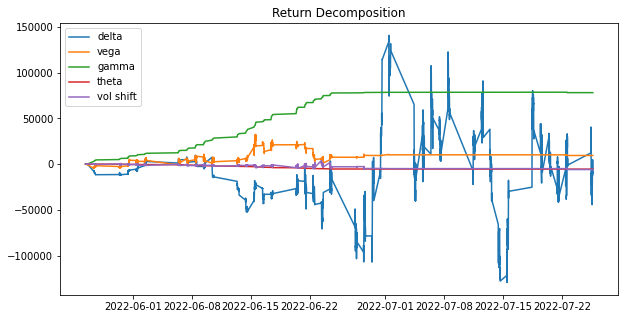

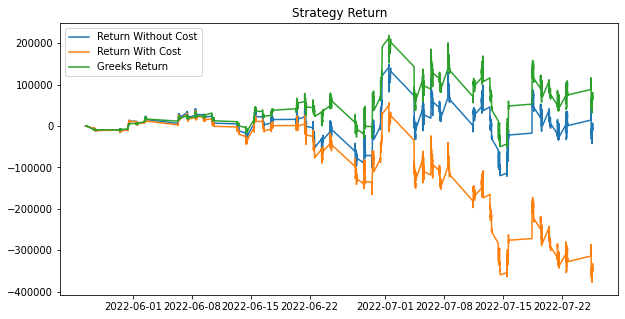

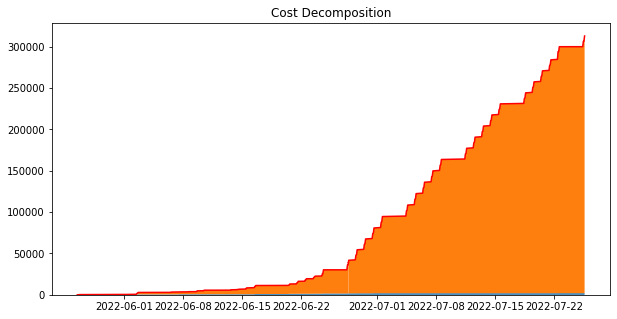

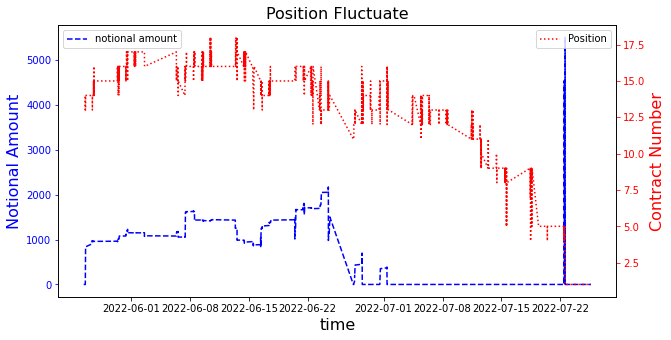

   annualized return  sharpe ratio  maximum drawdown  win ratio
0          -0.431775      -1.89569         -0.099389   0.475974


0

In [35]:
Backtest(pcpl1)

In [37]:
pcpl2.profit_position = pcpl2.profit_position*-1
pcpl2.hedge_position = pcpl2.hedge_position*-1

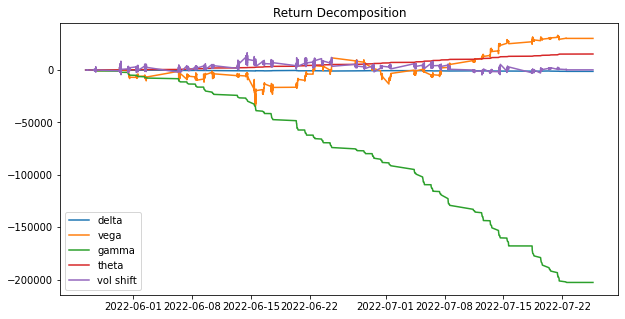

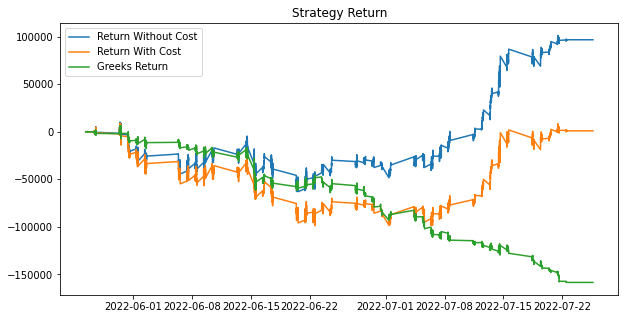

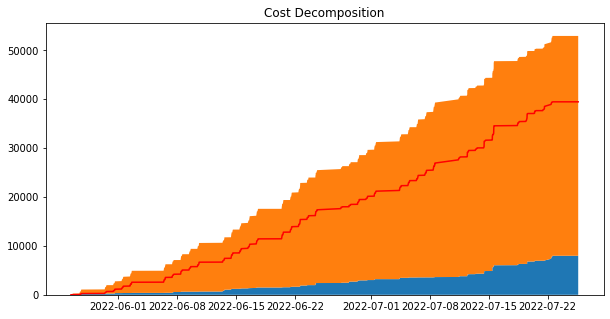

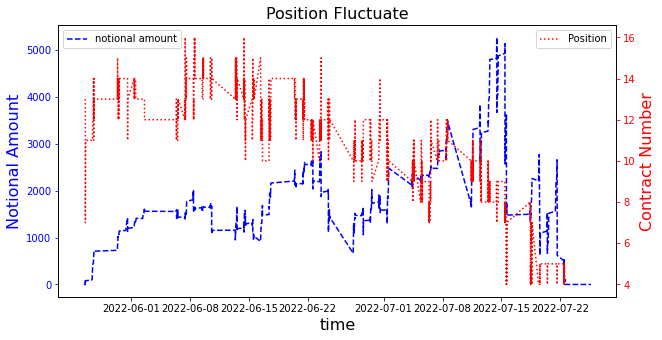

   annualized return  sharpe ratio  maximum drawdown  win ratio
0          -0.012349     -1.015828         -0.012701   0.501308


0

In [38]:
Backtest(pcpl2)

In [27]:
pcpl2.to_csv("/content/drive/MyDrive/Huatai_ml_model/lasso_strat2_close_51.csv")

single signal test

In [39]:
work_path = "/content/drive/MyDrive/SabrSummerProject2022/"
sys.path.append(work_path + '/02_src/OptionModel')
from sabr_bywynn import BlackScholes, SABR
sabr2207 = pd.read_csv(work_path + '/03_data/300etf_2207_sabr_v1.csv',index_col = 0)
sabr2207 = sabr2207.loc[:26173, :]
sabr2207.time = pd.to_datetime(sabr2207.time)
#f = open(os.path.join(data_path, '300etf_2208_sabr_v1.pkl'),'rb')
#sabr2207 = pickle.load(f)

'''
f = open(os.path.join(data_path, 'greeks_2207_v1.pkl'),'rb')
sabr2207s = pickle.load(f)
sabr2207s = sabr2207s.rename(columns = {'bs_iv':'black vol', 'sabr_iv':'sabr vol', 'strike':'strike price'})
sabr2207s = sabr2207s.reset_index()
'''

etf = pd.read_csv(work_path + "/03_data/300etf.csv",index_col = 0)
etf['time'] = pd.to_datetime(etf['time'])
etf = etf.set_index('time').reindex(pd.Index(np.unique(sabr2207['time']))).reset_index()
etf = etf.rename(columns = {'index':'time'})

'''
volatility spread to generate expected price spread
'''
sabr2207 = sabr2207.loc[(np.abs(sabr2207['delta']) < 0.9)&(np.abs(sabr2207['delta']) > 0.1), :]

def gen_price(x):
    isCall = x['type'].apply(lambda x: True if x == 'C' else False)
    bs = BlackScholes(x['strike price'], x['time_to_mature'].values[0], x['spot price'].values[0], x['riskfree rate'].values[0], isCall)
    x['price'] = bs.black(x['sabr vol'])   
    return x

sabr2207 = sabr2207.groupby('time').apply(gen_price)

In [40]:
import talib
sabr2207 = sabr2207.rename(columns={'price':'sabr_value'})
vol_beta = sabr2207.groupby('time',as_index=True).progress_apply(lambda x:beta_calculation(x))
sabr2207 = pd.merge(sabr2207,vol_beta[["code","time","beta","beta_ols_diff","beta_diff","beta_avg_diff",'atm_IV']],on = ["code","time"])
sabr2207 = sabr2207.groupby('code').progress_apply(lambda x:feature_engineering_vol(x))

my bars:: 100%|██████████| 27/27 [00:00<00:00, 65.18it/s]


In [80]:
#set single signal and some smoothing or signal strengthen method
sabr2207_strat = sabr2207.copy()
sabr2207_strat = sabr2207_strat.sort_values(['code','time'])
sabr2207_strat['signal'] = sabr2207_strat.sabr_value_diff
sabr2207_strat['signal'] = sabr2207_strat['signal'].replace({np.inf:0,-np.inf:0})
#sabr2207_strat['signal'] = sabr2207_strat.groupby('code').apply(lambda x:talib.EMA(x['signal'],5)).values
#sabr2207_strat['signal'] = sabr2207_strat.groupby('code').apply(lambda x:x.rolling(20).apply(lambda x:20 - x.argmin())).values
#sabr2207_strat['signal'] = -sabr2207_strat.groupby('code').apply(lambda x:x.rolling(20).apply(lambda x:20 - x.argmax())).values
sabr2207_strat[['signal','delta', 'vega', 'gamma', 'theta']] = sabr2207_strat.groupby('code')[['signal','delta', 'vega', 'gamma', 'theta']].shift()

In [81]:
# param_dict_ = {'by_rank':2, 'symmetry':True}
# strat = sabr2207_strat.groupby('time').apply(hedge_update.Option_Split_Rank, **param_dict_)
# pcpl1 = hedge_update.Hedge_Transform(strat, etf)
# hedge_update.Global_Exist(pcpl1)
# pcpl1 = pcpl1.groupby('time').progress_apply(hedge_update.Option_Position_Add).reset_index(drop = True)
# # temp.to_csv('/Users/chenwynn/Documents/Intern_project/HTSC_Summer/sabr_vol/add.csv')
# hedge_update.Global_Exist(pcpl1)
# hedge_dict_ = {'bar':8e-4, 'delta_tolerance':5, 'vega_tolerance':5}
# pcpl1 = pcpl1.groupby('time').progress_apply(hedge_update.Hedge_Vega, **hedge_dict_).reset_index(drop = True)

# strategy 1
sabr2207_strat = sabr2207_strat.sort_values(["time","code"])
param_dict_ = {'profit':1e-3, 'hedge':8e-4, 'delta_tolerance':20, 'vega_tolerance':90, 'trade_volume':100, 'quota':0.5}
pcpl1 = hedge_update.Hedge_Transform(sabr2207_strat, etf)
pcpl1['profit_position'] = 0
hedge_update.Global_Exist(pcpl1)
pcpl1 = pcpl1.groupby('time').progress_apply(hedge_update.Hedge_Open, **param_dict_).reset_index(drop = True)
pcpl1['open price'] = pcpl1.groupby('code')['close'].shift()

my bars::   0%|          | 7/2016 [00:00<01:36, 20.77it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::   1%|          | 12/2016 [00:00<01:46, 18.84it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::   1%|▏         | 28/2016 [00:01<01:16, 25.87it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::   2%|▏         | 36/2016 [00:01<01:06, 29.87it/s]

Optimization terminated successfully


my bars::   3%|▎         | 53/2016 [00:01<01:10, 27.82it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::   3%|▎         | 60/2016 [00:02<01:23, 23.35it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::   3%|▎         | 66/2016 [00:02<01:21, 23.83it/s]

Optimization terminated successfully


my bars::   5%|▍         | 99/2016 [00:03<00:59, 32.49it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::   6%|▌         | 124/2016 [00:04<00:54, 34.46it/s]

Optimization terminated successfully


my bars::   7%|▋         | 132/2016 [00:04<00:56, 33.47it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::   8%|▊         | 152/2016 [00:05<00:58, 31.88it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::   9%|▊         | 176/2016 [00:05<00:55, 33.28it/s]

Optimization terminated successfully


my bars::   9%|▉         | 184/2016 [00:06<01:00, 30.27it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  10%|▉         | 200/2016 [00:06<01:02, 28.91it/s]

Optimization terminated successfully


my bars::  10%|█         | 207/2016 [00:07<01:15, 23.96it/s]

Optimization terminated successfully


my bars::  11%|█         | 213/2016 [00:07<01:22, 21.99it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  11%|█         | 216/2016 [00:07<01:23, 21.50it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  11%|█         | 222/2016 [00:07<01:32, 19.40it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  12%|█▏        | 234/2016 [00:08<01:00, 29.35it/s]

Optimization terminated successfully


my bars::  12%|█▏        | 241/2016 [00:08<01:14, 23.88it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  12%|█▏        | 247/2016 [00:08<01:14, 23.76it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  13%|█▎        | 258/2016 [00:09<01:06, 26.49it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  14%|█▍        | 283/2016 [00:09<00:55, 31.50it/s]

Optimization terminated successfully


my bars::  14%|█▍        | 291/2016 [00:10<00:58, 29.34it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  15%|█▍        | 295/2016 [00:10<01:06, 26.04it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  15%|█▌        | 306/2016 [00:10<01:10, 24.17it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  15%|█▌        | 312/2016 [00:11<01:16, 22.17it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  16%|█▌        | 318/2016 [00:11<01:21, 20.96it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  16%|█▌        | 324/2016 [00:11<01:15, 22.53it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  16%|█▋        | 330/2016 [00:11<01:16, 21.94it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  17%|█▋        | 333/2016 [00:12<01:18, 21.34it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  17%|█▋        | 339/2016 [00:12<01:27, 19.08it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  17%|█▋        | 343/2016 [00:12<01:37, 17.12it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  17%|█▋        | 351/2016 [00:13<01:09, 24.08it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  18%|█▊        | 359/2016 [00:13<00:57, 28.72it/s]

Optimization terminated successfully


my bars::  18%|█▊        | 370/2016 [00:13<00:57, 28.63it/s]

Optimization terminated successfully


my bars::  19%|█▉        | 381/2016 [00:14<00:58, 28.13it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  19%|█▉        | 390/2016 [00:14<01:02, 25.87it/s]

Optimization terminated successfully


my bars::  20%|█▉        | 399/2016 [00:14<00:54, 29.55it/s]

Optimization terminated successfully


my bars::  21%|██        | 416/2016 [00:15<01:00, 26.53it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  21%|██        | 422/2016 [00:15<01:08, 23.41it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  21%|██▏       | 429/2016 [00:15<01:08, 23.03it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  22%|██▏       | 444/2016 [00:16<00:54, 28.97it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  23%|██▎       | 457/2016 [00:16<00:56, 27.52it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  23%|██▎       | 463/2016 [00:17<01:01, 25.25it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  23%|██▎       | 469/2016 [00:17<01:01, 25.03it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  24%|██▎       | 475/2016 [00:17<01:01, 25.11it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  24%|██▍       | 485/2016 [00:17<00:58, 26.39it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  24%|██▍       | 491/2016 [00:18<01:01, 24.84it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  25%|██▍       | 497/2016 [00:18<01:02, 24.15it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  25%|██▌       | 507/2016 [00:18<01:00, 25.01it/s]

Optimization terminated successfully


my bars::  25%|██▌       | 514/2016 [00:19<00:59, 25.19it/s]

Optimization terminated successfully


my bars::  26%|██▌       | 523/2016 [00:19<01:06, 22.51it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  26%|██▌       | 529/2016 [00:19<01:10, 21.18it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  27%|██▋       | 535/2016 [00:20<01:12, 20.45it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  27%|██▋       | 542/2016 [00:20<01:15, 19.51it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  27%|██▋       | 544/2016 [00:20<01:23, 17.55it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  27%|██▋       | 548/2016 [00:21<01:52, 13.01it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  28%|██▊       | 557/2016 [00:21<01:15, 19.28it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  28%|██▊       | 564/2016 [00:21<01:01, 23.72it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  29%|██▉       | 581/2016 [00:22<00:52, 27.45it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  29%|██▉       | 588/2016 [00:22<00:56, 25.07it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  30%|██▉       | 602/2016 [00:23<00:50, 28.20it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  30%|███       | 605/2016 [00:23<00:56, 24.99it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  30%|███       | 611/2016 [00:23<00:54, 25.76it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  31%|███       | 618/2016 [00:23<00:52, 26.48it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  31%|███       | 624/2016 [00:23<00:57, 24.39it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  31%|███       | 627/2016 [00:24<01:03, 21.96it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  31%|███▏      | 634/2016 [00:24<01:01, 22.32it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  32%|███▏      | 640/2016 [00:24<01:00, 22.92it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  32%|███▏      | 647/2016 [00:24<00:54, 25.00it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  33%|███▎      | 658/2016 [00:25<00:50, 27.02it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  33%|███▎      | 664/2016 [00:25<00:55, 24.57it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  33%|███▎      | 670/2016 [00:25<00:59, 22.76it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  33%|███▎      | 673/2016 [00:26<01:01, 21.92it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  34%|███▎      | 679/2016 [00:26<01:07, 19.83it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  34%|███▍      | 684/2016 [00:26<01:11, 18.68it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  34%|███▍      | 690/2016 [00:26<01:04, 20.66it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  35%|███▍      | 702/2016 [00:27<00:45, 28.96it/s]

Optimization terminated successfully


my bars::  35%|███▌      | 711/2016 [00:27<00:46, 28.00it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  36%|███▌      | 719/2016 [00:27<00:42, 30.43it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  36%|███▋      | 732/2016 [00:28<00:46, 27.71it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  37%|███▋      | 746/2016 [00:28<00:41, 30.52it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  38%|███▊      | 764/2016 [00:29<00:36, 34.00it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  38%|███▊      | 773/2016 [00:29<00:40, 31.06it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  39%|███▊      | 780/2016 [00:29<00:48, 25.29it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  39%|███▉      | 783/2016 [00:30<00:55, 22.32it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  40%|███▉      | 799/2016 [00:30<00:44, 27.59it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  40%|███▉      | 806/2016 [00:30<00:43, 27.54it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  40%|████      | 812/2016 [00:31<00:43, 27.67it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  41%|████      | 818/2016 [00:31<00:50, 23.68it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  41%|████      | 831/2016 [00:31<00:46, 25.75it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  41%|████▏     | 834/2016 [00:31<00:49, 23.74it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  42%|████▏     | 844/2016 [00:32<00:45, 25.99it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  42%|████▏     | 852/2016 [00:32<00:39, 29.48it/s]

Optimization terminated successfully


my bars::  43%|████▎     | 867/2016 [00:32<00:35, 32.20it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  43%|████▎     | 871/2016 [00:33<00:39, 29.03it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  44%|████▎     | 880/2016 [00:33<00:39, 28.86it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  44%|████▍     | 886/2016 [00:33<00:42, 26.84it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  44%|████▍     | 895/2016 [00:34<00:38, 29.07it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  45%|████▍     | 902/2016 [00:34<00:43, 25.73it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  45%|████▌     | 908/2016 [00:34<00:43, 25.26it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  45%|████▌     | 917/2016 [00:34<00:44, 24.45it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  46%|████▌     | 923/2016 [00:35<00:44, 24.63it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  46%|████▌     | 929/2016 [00:35<00:42, 25.46it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  47%|████▋     | 939/2016 [00:35<00:32, 32.92it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  47%|████▋     | 955/2016 [00:35<00:24, 42.87it/s]

Optimization terminated successfully


my bars::  48%|████▊     | 964/2016 [00:36<00:31, 32.99it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  48%|████▊     | 972/2016 [00:36<00:35, 29.19it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  49%|████▊     | 981/2016 [00:36<00:30, 34.09it/s]

Optimization terminated successfully


my bars::  49%|████▉     | 989/2016 [00:37<00:31, 33.04it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  49%|████▉     | 997/2016 [00:37<00:31, 32.84it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  50%|█████     | 1010/2016 [00:37<00:29, 34.67it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  50%|█████     | 1018/2016 [00:37<00:28, 34.86it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  51%|█████     | 1026/2016 [00:38<00:28, 34.40it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  51%|█████▏    | 1038/2016 [00:38<00:29, 33.71it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  52%|█████▏    | 1046/2016 [00:38<00:32, 30.06it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  52%|█████▏    | 1050/2016 [00:39<00:37, 25.91it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  52%|█████▏    | 1056/2016 [00:39<00:41, 22.94it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  53%|█████▎    | 1059/2016 [00:39<00:42, 22.62it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  53%|█████▎    | 1065/2016 [00:39<00:44, 21.17it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  53%|█████▎    | 1072/2016 [00:40<00:37, 25.35it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  54%|█████▎    | 1081/2016 [00:40<00:38, 24.49it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  54%|█████▍    | 1089/2016 [00:40<00:35, 26.12it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  54%|█████▍    | 1096/2016 [00:40<00:30, 30.14it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  55%|█████▍    | 1104/2016 [00:41<00:32, 27.87it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  55%|█████▌    | 1112/2016 [00:41<00:32, 27.48it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  56%|█████▌    | 1121/2016 [00:41<00:26, 34.35it/s]

Optimization terminated successfully


my bars::  56%|█████▌    | 1129/2016 [00:41<00:25, 34.23it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  56%|█████▋    | 1137/2016 [00:42<00:27, 31.99it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  57%|█████▋    | 1141/2016 [00:42<00:29, 29.54it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  57%|█████▋    | 1150/2016 [00:42<00:28, 29.95it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  57%|█████▋    | 1154/2016 [00:42<00:32, 26.92it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  58%|█████▊    | 1161/2016 [00:43<00:33, 25.62it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  58%|█████▊    | 1168/2016 [00:43<00:30, 28.17it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  59%|█████▉    | 1191/2016 [00:43<00:21, 37.61it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  60%|█████▉    | 1200/2016 [00:44<00:23, 34.00it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  60%|█████▉    | 1209/2016 [00:44<00:21, 37.31it/s]

Optimization terminated successfully


my bars::  60%|██████    | 1218/2016 [00:44<00:26, 30.25it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  61%|██████    | 1222/2016 [00:44<00:28, 28.21it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  61%|██████    | 1232/2016 [00:45<00:23, 33.07it/s]

Optimization terminated successfully


my bars::  62%|██████▏   | 1243/2016 [00:45<00:18, 41.09it/s]

Optimization terminated successfully


my bars::  62%|██████▏   | 1252/2016 [00:45<00:22, 34.45it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  62%|██████▎   | 1260/2016 [00:45<00:27, 27.95it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  63%|██████▎   | 1270/2016 [00:46<00:27, 27.50it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  63%|██████▎   | 1275/2016 [00:46<00:22, 32.51it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  64%|██████▎   | 1283/2016 [00:46<00:21, 33.38it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  64%|██████▍   | 1295/2016 [00:47<00:22, 32.38it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  65%|██████▍   | 1303/2016 [00:47<00:21, 33.83it/s]

Optimization terminated successfully


my bars::  65%|██████▌   | 1312/2016 [00:47<00:20, 33.92it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  66%|██████▌   | 1321/2016 [00:47<00:19, 35.66it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  66%|██████▌   | 1334/2016 [00:48<00:19, 34.84it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  67%|██████▋   | 1342/2016 [00:48<00:20, 33.36it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  67%|██████▋   | 1350/2016 [00:48<00:22, 29.39it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  67%|██████▋   | 1358/2016 [00:49<00:22, 28.83it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  68%|██████▊   | 1368/2016 [00:49<00:21, 29.89it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  68%|██████▊   | 1377/2016 [00:49<00:19, 32.31it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  69%|██████▉   | 1386/2016 [00:49<00:17, 36.97it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  69%|██████▉   | 1394/2016 [00:50<00:18, 32.84it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  70%|███████   | 1412/2016 [00:50<00:14, 42.45it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  71%|███████   | 1428/2016 [00:50<00:14, 41.46it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  71%|███████   | 1433/2016 [00:51<00:16, 34.80it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  72%|███████▏  | 1444/2016 [00:51<00:15, 36.47it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  72%|███████▏  | 1460/2016 [00:51<00:12, 43.92it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  74%|███████▍  | 1487/2016 [00:52<00:10, 51.05it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  74%|███████▍  | 1498/2016 [00:52<00:11, 44.43it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  75%|███████▍  | 1510/2016 [00:52<00:11, 45.75it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  77%|███████▋  | 1545/2016 [00:53<00:07, 59.50it/s]

Optimization terminated successfully


my bars::  77%|███████▋  | 1558/2016 [00:53<00:08, 53.15it/s]

Optimization terminated successfully


my bars::  78%|███████▊  | 1570/2016 [00:53<00:08, 52.21it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  79%|███████▉  | 1589/2016 [00:54<00:08, 50.36it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  81%|████████  | 1633/2016 [00:54<00:05, 64.68it/s]

Optimization terminated successfully


my bars::  82%|████████▏ | 1649/2016 [00:55<00:06, 56.75it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  83%|████████▎ | 1664/2016 [00:55<00:06, 53.17it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  84%|████████▍ | 1692/2016 [00:55<00:05, 60.50it/s]

Optimization terminated successfully


my bars::  86%|████████▌ | 1728/2016 [00:56<00:04, 61.45it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  87%|████████▋ | 1755/2016 [00:56<00:04, 55.59it/s]

Optimization terminated successfully


my bars::  89%|████████▉ | 1794/2016 [00:57<00:03, 68.61it/s]

Optimization terminated successfully


my bars::  91%|█████████▏| 1844/2016 [00:58<00:02, 72.82it/s]

Optimization terminated successfully


my bars::  96%|█████████▌| 1928/2016 [00:59<00:01, 65.63it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  97%|█████████▋| 1952/2016 [00:59<00:01, 60.93it/s]

Optimization terminated successfully


my bars:: 100%|██████████| 2016/2016 [01:01<00:00, 32.60it/s]


In [82]:

# strategy 2
# u0 = -1.8e-3
# u1 = -1e-3
# u2 = 0
# u3 = 6e-4
# u4 = 1e-3

param_dict_ = {'vega_tolerance':90, 'trade_volume':100, 'quota':0.5}
pcpl2 = hedge_update.Hedge_Transform(sabr2207_strat, etf)
pcpl2['profit_position'] = 0
quantile_num = 5
# pcpl1.loc[pcpl1['signal'] <= u0, 'group'] = 5
# pcpl1.loc[(pcpl1['signal'] <= u1)&(pcpl1['signal'] > u0), 'group'] = 4
# pcpl1.loc[(pcpl1['signal'] <= u2)&(pcpl1['signal'] > u1), 'group'] = 3
# pcpl1.loc[(pcpl1['signal'] <= u3)&(pcpl1['signal'] > u2), 'group'] = 2
# pcpl1.loc[(pcpl1['signal'] <= u4)&(pcpl1['signal'] > u3), 'group'] = 1
# pcpl1.loc[pcpl1['signal'] > u4, 'group'] = 0
pcpl2 = pcpl2.groupby("time").progress_apply(lambda x:quantile_group(x)).sort_values(["code","time"])
hedge_update.Global_Exist(pcpl1)
pcpl2 = pcpl2.groupby('time').progress_apply(hedge_update.Hedge_Open_Slow, **param_dict_)
pcpl2 = pcpl2.reset_index(drop=True)
pcpl2['open price'] = pcpl2.groupby('code')['close'].shift()
#pcpl1['position'] = pcpl1['profit_position'] + pcpl1['hedge_position']

my bars:: 100%|██████████| 2016/2016 [01:58<00:00, 17.05it/s]


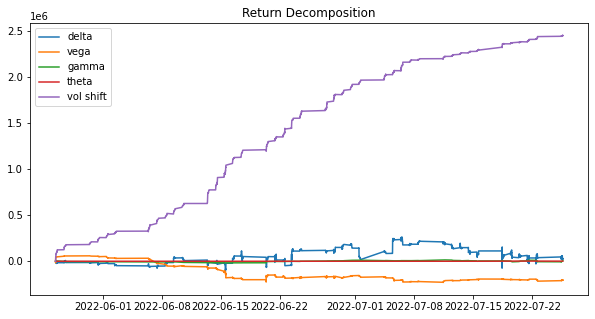

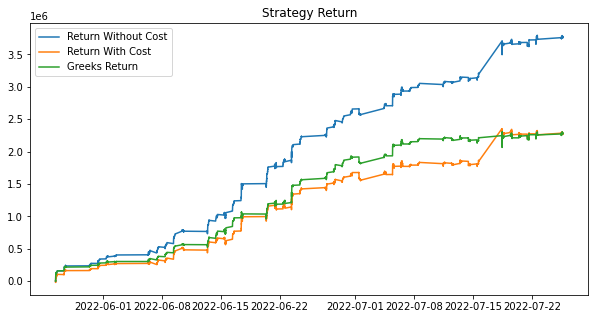

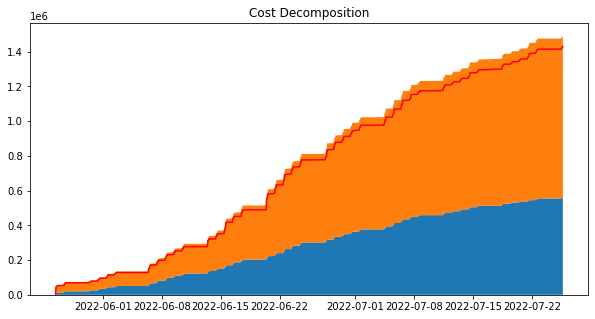

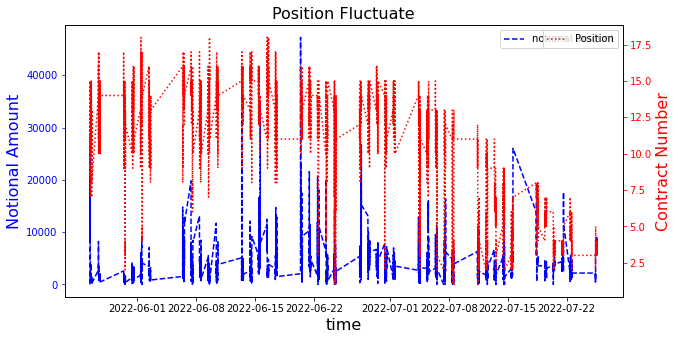

   annualized return  sharpe ratio  maximum drawdown  win ratio
0           0.251615       0.77642         -0.072145   0.525918


0

In [83]:
Backtest(pcpl1)

In [77]:
pcpl2.profit_position = pcpl2.profit_position*-1
pcpl2.hedge_position = pcpl2.hedge_position*-1

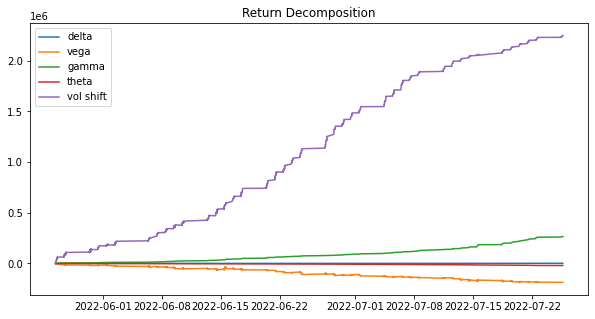

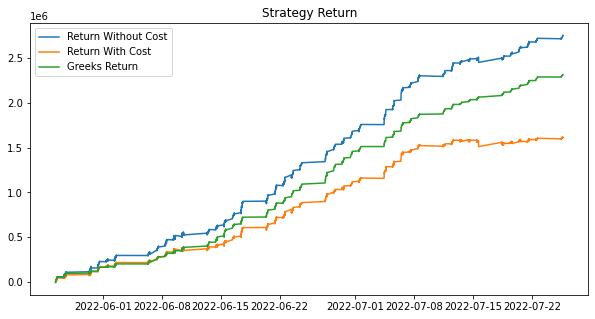

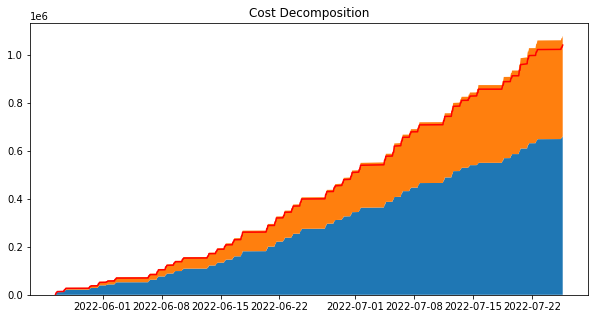

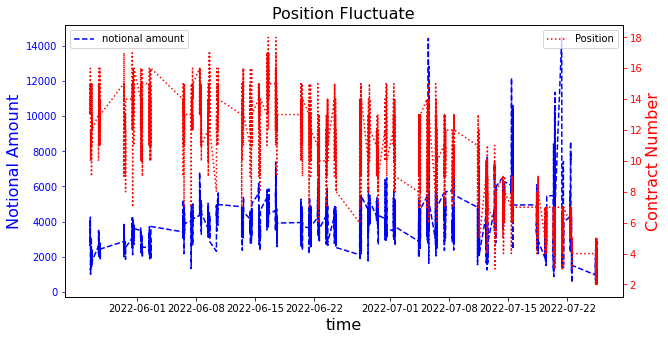

   annualized return  sharpe ratio  maximum drawdown  win ratio
0           0.200922      2.062718         -0.052332   0.541439


0

In [84]:
Backtest(pcpl2)

In [85]:
pcpl1.to_csv("/content/drive/MyDrive/Huatai_ml_model/sabr_value_diff_strat1.csv")
pcpl2.to_csv("/content/drive/MyDrive/Huatai_ml_model/sabr_value_diff_strat2.csv")

benchmark

In [9]:
sabr2207 = pd.read_csv(work_path + '/03_data/300etf_2207_sabr_v1.csv',index_col = 0)
sabr2207 = sabr2207.loc[:26173, :]
sabr2207.time = pd.to_datetime(sabr2207.time)
#f = open(os.path.join(data_path, '300etf_2208_sabr_v1.pkl'),'rb')
#sabr2207 = pickle.load(f)

'''
f = open(os.path.join(data_path, 'greeks_2207_v1.pkl'),'rb')
sabr2207s = pickle.load(f)
sabr2207s = sabr2207s.rename(columns = {'bs_iv':'black vol', 'sabr_iv':'sabr vol', 'strike':'strike price'})
sabr2207s = sabr2207s.reset_index()
'''

etf = pd.read_csv(work_path + "/03_data/300etf.csv",index_col = 0)
etf['time'] = pd.to_datetime(etf['time'])
etf = etf.set_index('time').reindex(pd.Index(np.unique(sabr2207['time']))).reset_index()
etf = etf.rename(columns = {'index':'time'})

'''
volatility spread to generate expected price spread
'''
sabr2207 = sabr2207.loc[(np.abs(sabr2207['delta']) < 0.9)&(np.abs(sabr2207['delta']) > 0.1), :]

def gen_price(x):
    isCall = x['type'].apply(lambda x: True if x == 'C' else False)
    bs = BlackScholes(x['strike price'], x['time_to_mature'].values[0], x['spot price'].values[0], x['riskfree rate'].values[0], isCall)
    x['price'] = bs.black(x['sabr vol'])   
    return x

sabr2207 = sabr2207.groupby('time').apply(gen_price)

#time0 = np.unique(sabr2207['time'])[0]
#time1 = np.unique(sabr2207['time'])[480]
#try1 = sabr2207.loc[(sabr2207['time']>=time0)&(sabr2207['time']<time1), :]


sabr2207['signal'] = sabr2207['close'] - sabr2207['price']
sabr2207[['signal','delta', 'vega', 'gamma', 'theta']] = sabr2207.groupby('code')[['signal','delta', 'vega', 'gamma', 'theta']].shift()

In [18]:
import hedge_update
# param_dict_ = {'by_rank':2, 'symmetry':True}
# strat = sabr2207.groupby('time').apply(hedge_update.Option_Split_Rank, **param_dict_)
# pcpl1 = hedge_update.Hedge_Transform(strat, etf)
# hedge_update.Global_Exist(pcpl1)
# pcpl1 = pcpl1.groupby('time').progress_apply(hedge_update.Option_Position_Add).reset_index(drop = True)
# hedge_update.Global_Exist(pcpl1)
# hedge_dict_ = {'bar':8e-4, 'delta_tolerance':5, 'vega_tolerance':5}
# pcpl1 = pcpl1.groupby('time').progress_apply(hedge_update.Hedge_Vega, **hedge_dict_).reset_index(drop = True)

# param_dict_ = {'profit':1e-3, 'hedge':8e-4, 'delta_tolerance':20, 'vega_tolerance':90, 'trade_volume':100, 'quota':0.5}
# pcpl1 = hedge_update.Hedge_Transform(sabr2207, etf)
# pcpl1['profit_position'] = 0
# hedge_update.Global_Exist(pcpl1)
# pcpl1 = pcpl1.groupby('time').progress_apply(hedge_update.Hedge_Open, **param_dict_).reset_index(drop = True)


# strategy 2
u0 = -1.8e-3
u1 = -1e-3
u2 = 0
u3 = 6e-4
u4 = 1e-3

param_dict_ = {'vega_tolerance':90, 'trade_volume':100, 'quota':0.5}
pcpl1 = hedge_update.Hedge_Transform(sabr2207, etf)
pcpl1['profit_position'] = 0
pcpl1.loc[pcpl1['signal'] <= u0, 'group'] = 5
pcpl1.loc[(pcpl1['signal'] <= u1)&(pcpl1['signal'] > u0), 'group'] = 4
pcpl1.loc[(pcpl1['signal'] <= u2)&(pcpl1['signal'] > u1), 'group'] = 3
pcpl1.loc[(pcpl1['signal'] <= u3)&(pcpl1['signal'] > u2), 'group'] = 2
pcpl1.loc[(pcpl1['signal'] <= u4)&(pcpl1['signal'] > u3), 'group'] = 1
pcpl1.loc[pcpl1['signal'] > u4, 'group'] = 0
hedge_update.Global_Exist(pcpl1)
pcpl1 = pcpl1.groupby('time').progress_apply(hedge_update.Hedge_Open_Slow, **param_dict_)
pcpl1 = pcpl1.reset_index(drop=True)
pcpl1['position'] = pcpl1['profit_position'] + pcpl1['hedge_position']

# 手续费
time0 = pcpl1['time'].sort_values().iloc[0]
timen = pcpl1['time'].sort_values().iloc[-1]

# 开仓价为上一个tick的close
pcpl1['open price'] = pcpl1.groupby('code')['close'].shift()

pcpl1['profit_position_diff'] = pcpl1.groupby('code')['profit_position'].diff()
pcpl1.loc[pcpl1['time'] == time0, 'profit_position_diff'] = pcpl1.loc[pcpl1['time'] == time0, 'profit_position']
# pcpl1.loc[pcpl1['time'] == timen, 'cash_diff'] = pcpl1.loc[pcpl1['time'] == timen, 'position'] * pcpl1.loc[pcpl1['time'] == timen, 'close']
pcpl1['profit_cost'] = np.abs(pcpl1['profit_position_diff']) * 1.3
pcpl1.loc[(pcpl1['position'] < 0)&(pcpl1['profit_position_diff'] < 0), 'profit_cost'] = 0

pcpl1['hedge_position_diff'] = pcpl1.groupby('code')['hedge_position'].diff()
pcpl1.loc[pcpl1['time'] == time0, 'hedge_position_diff'] = pcpl1.loc[pcpl1['time'] == time0, 'hedge_position']
pcpl1.loc[pcpl1['type'] != 'S', 'hedge_cost'] = np.abs(pcpl1.loc[pcpl1['type'] != 'S', 'hedge_position_diff']) * 1.3
pcpl1.loc[(pcpl1['type'] != 'S')&(pcpl1['position'] < 0)&(pcpl1['hedge_position_diff'] < 0), 'hedge_cost'] = 0
pcpl1.loc[pcpl1['type'] == 'S', 'hedge_cost'] = np.abs(pcpl1.loc[pcpl1['type'] == 'S', 'hedge_position_diff']) * 0.4 * pcpl1.loc[pcpl1['type'] == 'S', 'close']
pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['hedge_position'] < 0)&(pcpl1['hedge_position_diff'] < 0), 'hedge_cost'] = np.abs(pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['hedge_position'] < 0)&(pcpl1['hedge_position_diff'] < 0), 'hedge_position_diff']) * 3 * pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['hedge_position'] < 0)&(pcpl1['hedge_position_diff'] < 0), 'open price']

pcpl1['position_diff'] = pcpl1.groupby('code')['position'].diff()
pcpl1.loc[pcpl1['time'] == time0, 'position_diff'] = pcpl1.loc[pcpl1['time'] == time0, 'position']
pcpl1.loc[pcpl1['type'] != 'S', 'cost'] = np.abs(pcpl1.loc[pcpl1['type'] != 'S', 'position_diff']) * 1.3
pcpl1.loc[(pcpl1['type'] != 'S')&(pcpl1['position'] < 0)&(pcpl1['position_diff'] < 0), 'cost'] = 0
pcpl1.loc[pcpl1['type'] == 'S', 'cost'] = np.abs(pcpl1.loc[pcpl1['type'] == 'S', 'position_diff']) * 0.4 * pcpl1.loc[pcpl1['type'] == 'S', 'close']
pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['position'] < 0)&(pcpl1['position_diff'] < 0), 'cost'] = np.abs(pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['position'] < 0)&(pcpl1['position_diff'] < 0), 'position_diff']) * 3 * pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['position'] < 0)&(pcpl1['position_diff'] < 0), 'open price']


# cash = pcpl1.groupby('time')['cash_diff'].sum()

pcpl1['cash'] = pcpl1['close'] - pcpl1['open price']
pcpl1['cash'] = pcpl1['cash'] * pcpl1['position'] * 10000
pcpl1.loc[pcpl1['type'] == 'C', 'out moneyness'] = (-pcpl1.loc[pcpl1['type'] == 'C', 'close'] + pcpl1.loc[pcpl1['type'] == 'C', 'strike price']).apply(lambda x: max(x, 0))
pcpl1.loc[pcpl1['type'] == 'P', 'out moneyness'] = (pcpl1.loc[pcpl1['type'] == 'P', 'close'] - pcpl1.loc[pcpl1['type'] == 'P', 'strike price']).apply(lambda x: max(x, 0))
pcpl1['margin'] = pcpl1.apply(lambda x:max(-(min(x['open price'] + max(0.12*x['spot price'] - x['out moneyness'], 0.07 * x['strike price']), x['strike price'])) * 1e4 * x['position'], x['open price'] * x['position'] * 1e4), axis = 1)
pcpl1['fund_cost'] = pcpl1['margin'] * 0.04/250/48
pcpl1['fund_cost'] = pcpl1['fund_cost'].fillna(0)
pcpl1['cost'] = pcpl1['cost'].fillna(0)
pcpl1['cash_net'] = pcpl1['cash'] - pcpl1['cost'] - pcpl1['fund_cost']
# cash = pcpl1.groupby('time')['cash'].sum()

my bars:: 100%|██████████| 2016/2016 [02:42<00:00, 12.37it/s]


In [19]:
time0 = pcpl1['time'].sort_values().iloc[0]
timen = pcpl1['time'].sort_values().iloc[-1]

# 开仓价为上一个tick的close
pcpl1['open price'] = pcpl1.groupby('code')['close'].shift()

pcpl1['profit_position_diff'] = pcpl1.groupby('code')['profit_position'].diff()
pcpl1.loc[pcpl1['time'] == time0, 'profit_position_diff'] = pcpl1.loc[pcpl1['time'] == time0, 'profit_position']
# pcpl1.loc[pcpl1['time'] == timen, 'cash_diff'] = pcpl1.loc[pcpl1['time'] == timen, 'position'] * pcpl1.loc[pcpl1['time'] == timen, 'close']
pcpl1['profit_cost'] = np.abs(pcpl1['profit_position_diff']) * 1.3
pcpl1.loc[(pcpl1['position'] < 0)&(pcpl1['profit_position_diff'] < 0), 'profit_cost'] = 0

pcpl1['hedge_position_diff'] = pcpl1.groupby('code')['hedge_position'].diff()
pcpl1.loc[pcpl1['time'] == time0, 'hedge_position_diff'] = pcpl1.loc[pcpl1['time'] == time0, 'hedge_position']
pcpl1.loc[pcpl1['type'] != 'S', 'hedge_cost'] = np.abs(pcpl1.loc[pcpl1['type'] != 'S', 'hedge_position_diff']) * 1.3
pcpl1.loc[(pcpl1['type'] != 'S')&(pcpl1['position'] < 0)&(pcpl1['hedge_position_diff'] < 0), 'hedge_cost'] = 0
pcpl1.loc[pcpl1['type'] == 'S', 'hedge_cost'] = np.abs(pcpl1.loc[pcpl1['type'] == 'S', 'hedge_position_diff']) * 0.4 * pcpl1.loc[pcpl1['type'] == 'S', 'close']
pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['hedge_position'] < 0)&(pcpl1['hedge_position_diff'] < 0), 'hedge_cost'] = np.abs(pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['hedge_position'] < 0)&(pcpl1['hedge_position_diff'] < 0), 'hedge_position_diff']) * 3 * pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['hedge_position'] < 0)&(pcpl1['hedge_position_diff'] < 0), 'open price']

pcpl1['position_diff'] = pcpl1.groupby('code')['position'].diff()
pcpl1.loc[pcpl1['time'] == time0, 'position_diff'] = pcpl1.loc[pcpl1['time'] == time0, 'position']
pcpl1.loc[pcpl1['type'] != 'S', 'cost'] = np.abs(pcpl1.loc[pcpl1['type'] != 'S', 'position_diff']) * 1.3
pcpl1.loc[(pcpl1['type'] != 'S')&(pcpl1['position'] < 0)&(pcpl1['position_diff'] < 0), 'cost'] = 0
pcpl1.loc[pcpl1['type'] == 'S', 'cost'] = np.abs(pcpl1.loc[pcpl1['type'] == 'S', 'position_diff']) * 0.4 * pcpl1.loc[pcpl1['type'] == 'S', 'close']
pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['position'] < 0)&(pcpl1['position_diff'] < 0), 'cost'] = np.abs(pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['position'] < 0)&(pcpl1['position_diff'] < 0), 'position_diff']) * 3 * pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['position'] < 0)&(pcpl1['position_diff'] < 0), 'open price']


# cash = pcpl1.groupby('time')['cash_diff'].sum()

pcpl1['cash'] = pcpl1['close'] - pcpl1['open price']
pcpl1['cash'] = pcpl1['cash'] * pcpl1['position'] * 10000
pcpl1.loc[pcpl1['type'] == 'C', 'out moneyness'] = (-pcpl1.loc[pcpl1['type'] == 'C', 'close'] + pcpl1.loc[pcpl1['type'] == 'C', 'strike price']).apply(lambda x: max(x, 0))
pcpl1.loc[pcpl1['type'] == 'P', 'out moneyness'] = (pcpl1.loc[pcpl1['type'] == 'P', 'close'] - pcpl1.loc[pcpl1['type'] == 'P', 'strike price']).apply(lambda x: max(x, 0))
pcpl1['margin'] = pcpl1.apply(lambda x:max(-(min(x['open price'] + max(0.12*x['spot price'] - x['out moneyness'], 0.07 * x['strike price']), x['strike price'])) * 1e4 * x['position'], x['open price'] * x['position'] * 1e4), axis = 1)
pcpl1['fund_cost'] = pcpl1['margin'] * 0.04/250/48
pcpl1['fund_cost'] = pcpl1['fund_cost'].fillna(0)
pcpl1['cost'] = pcpl1['cost'].fillna(0)
pcpl1['cash_net'] = pcpl1['cash'] - pcpl1['cost'] - pcpl1['fund_cost']

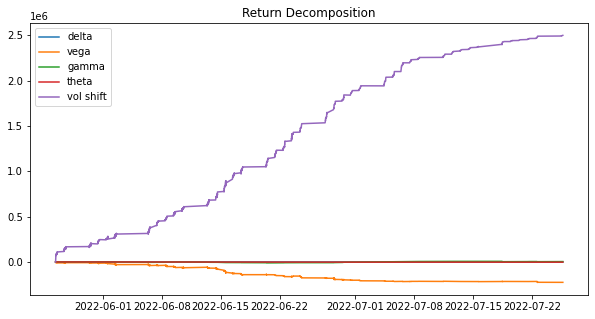

In [20]:
plt.figure(figsize=(10, 5))
plt.title('Return Decomposition')
pcpl1['delta_p'] = pcpl1['delta']*pcpl1['position']
delta_p = pcpl1.groupby('time')['delta_p'].sum()
delta_p = (pcpl1.loc[pcpl1['type'] == 'S', 'close'].diff()).values * delta_p * 1e4
pcpl1['vega_p'] = pcpl1.groupby('code')['sabr vol'].diff()
pcpl1['arbi'] = pcpl1.groupby('code')['black vol'].diff() - pcpl1['vega_p']
pcpl1['arbi'] = pcpl1['arbi'] * pcpl1['vega'].values * pcpl1['position'].values * 1e4
pcpl1['vega_p'] = pcpl1['vega_p'] * pcpl1['vega'].values * pcpl1['position'].values * 1e4
pcpl1['gamma_p'] = pcpl1['gamma']*pcpl1['position'].values
gamma_p = pcpl1.groupby('time')['gamma_p'].sum()
gamma_p = ((pcpl1.loc[pcpl1['type'] == 'S', 'close'].diff()).values)**2 * gamma_p/2 * 1e4
pcpl1['theta_p'] = pcpl1.groupby('code')['time_to_mature'].diff()
pcpl1['theta_p'] = pcpl1['theta_p'] * pcpl1['theta'].values * pcpl1['position'].values * 1e4
plt.plot(delta_p.cumsum(), label='delta')
plt.plot(pcpl1.groupby('time')['vega_p'].sum().cumsum(), label='vega')
plt.plot(gamma_p.cumsum(), label='gamma')
plt.plot(pcpl1.groupby('time')['theta_p'].sum().cumsum(), label='theta')
plt.plot(pcpl1.groupby('time')['arbi'].sum().cumsum(), label = 'vol shift')
plt.legend()

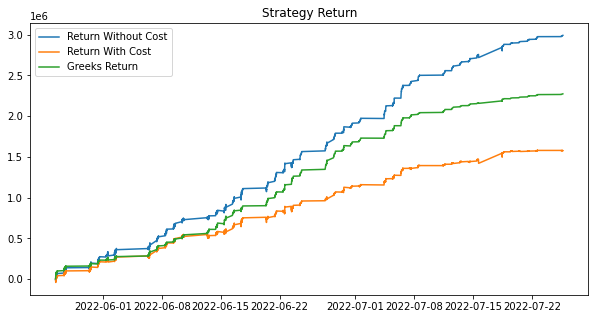

In [21]:
plt.figure(figsize = (10, 5))
plt.title('Strategy Return')
plt.plot(pcpl1.groupby('time')['cash'].sum().cumsum(), label = 'Return Without Cost')
plt.plot(pcpl1.groupby('time')['cash_net'].sum().cumsum(), label = 'Return With Cost')
plt.plot(delta_p.cumsum()+pcpl1.groupby('time')['vega_p'].sum().cumsum()+gamma_p.cumsum()+pcpl1.groupby('time')['theta_p'].sum().cumsum()+pcpl1.groupby('time')['arbi'].sum().cumsum(), label='Greeks Return')
plt.legend()